<a href="https://colab.research.google.com/github/shre2398/TensorflowForAI/blob/main/horse_and_human_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download datasets

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2021-05-16 05:03:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 142.250.65.80, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   149MB/s    in 1.0s    

2021-05-16 05:04:00 (149 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-05-16 05:04:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.164.144, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114

## Unzip the downloaded dataset and define directories

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [3]:
train_horse_dir = os.path.join('/tmp/horse-or-human', 'horses')
train_human_dir = os.path.join('/tmp/horse-or-human', 'humans')

validation_horse_dir = os.path.join('/tmp/validation-horse-or-human', 'horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human', 'humans')

## Building a small model from scratch

In [4]:
import tensorflow as tf

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3,), activation='relu', input_shape=(300, 300, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3,), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3,), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),    
  tf.keras.layers.Conv2D(64, (3,3,), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),    
  tf.keras.layers.Conv2D(64, (3,3,), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [7]:
from tensorflow.keras.optimizers import RMSprop

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

## Data Preprocessing

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Rescale images by 1./255
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow images in batches of 128 using data generator
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',
    target_size=(300, 300), # resize all images to 300x300
    batch_size=128,
    class_mode='binary' # since we use binary_crossentropy, we need binary labels
)

validation_generator = validation_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human/',
    target_size=(300, 300), # resize all images to 300x300
    batch_size=32,
    class_mode='binary' # since we use binary_crossentropy, we need binary labels
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Training

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=100,
    verbose=2,
    validation_data = validation_generator,
    validation_steps = 8
)

Epoch 1/100
8/8 - 53s - loss: 0.6928 - accuracy: 0.5217 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 2/100
8/8 - 21s - loss: 0.6961 - accuracy: 0.5184 - val_loss: 0.6813 - val_accuracy: 0.5000
Epoch 3/100
8/8 - 21s - loss: 0.6799 - accuracy: 0.5484 - val_loss: 0.6452 - val_accuracy: 0.8906
Epoch 4/100
8/8 - 21s - loss: 0.6863 - accuracy: 0.6185 - val_loss: 0.6308 - val_accuracy: 0.5000
Epoch 5/100
8/8 - 21s - loss: 0.6740 - accuracy: 0.6196 - val_loss: 0.7087 - val_accuracy: 0.5000
Epoch 6/100
8/8 - 21s - loss: 0.6560 - accuracy: 0.5895 - val_loss: 0.6342 - val_accuracy: 0.5430
Epoch 7/100
8/8 - 21s - loss: 0.6309 - accuracy: 0.6674 - val_loss: 0.5645 - val_accuracy: 0.7461
Epoch 8/100
8/8 - 22s - loss: 0.6616 - accuracy: 0.6852 - val_loss: 0.5503 - val_accuracy: 0.7461
Epoch 9/100
8/8 - 24s - loss: 0.5900 - accuracy: 0.7793 - val_loss: 0.6089 - val_accuracy: 0.5781
Epoch 10/100
8/8 - 21s - loss: 0.5840 - accuracy: 0.7119 - val_loss: 0.6199 - val_accuracy: 0.5742
Epoch 11/100
8/8 - 

## Evaluating Accuracy and Loss for the model

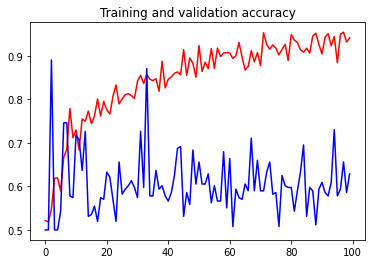

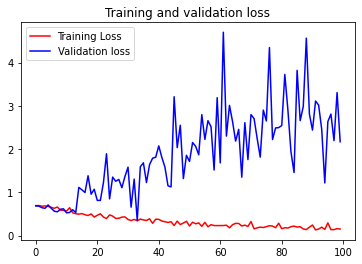

In [13]:
#---------------------------------------------
# Retrive list of results on training and test 
# data sets for each training epoch
#---------------------------------------------
import matplotlib.pyplot as plt
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, 'r', label="Training accuracy")
plt.plot  ( epochs, val_acc , 'b', label="Validation accuracy")
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , 'r', label="Training Loss")
plt.plot  ( epochs, val_loss , 'b', label="Validation loss")
plt.title ('Training and validation loss')
plt.legend()

plt.show()